In [1]:
%cd /home/anthony/projects/skmob_mmc_mobility/

/home/anthony/projects/skmob_mmc_mobility


In [2]:
import json
import os
import shutil
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append( '/home/anthony/projects/skmob_mmc_mobility/programs')

from matplotlib.pyplot import title
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm

from config import PATH_LOCAL_DATA, PATH_S3_EXPERIMENTS
from gan_utils.dpgan_tf2 import DPGAN
from gan_utils.gan_tf3 import GAN
from gan_utils.gan_utils import (get_optimizers, 
                                get_data, 
                                get_generated_data, 
                                get_data_user_conjoined, 
                                plot_user_geodata)
from gan_utils.s3_utils import upload_file_to_s3                            

warnings.filterwarnings('ignore')

2022-05-04 21:33:53.229177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 21:33:53.229228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-05-04 21:33:55.119740: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2022-05-04 21:33:55.119798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0C6FICR): /proc/driver/nvidia/version does not exist


In [4]:
path_data = os.path.join(PATH_LOCAL_DATA, 'users')
path_output= os.path.join(PATH_LOCAL_DATA, 'users_gan')
filename = 'data_user_002.csv'
nepochs = 2000
param = {'batch_size': 256,
            'discriminatorDims': [64, 32, 16, 1],
            'generatorDims': [512,16, 3],
            'input_dim': 3,
            'optimizer': 'Adam',
            'random_dim': 100
            }
upload_to_s3 = False
scale_data = False

In [5]:
start_time = time.time()


In [6]:
for path in [path_data, path_output]:
    if not os.path.exists(path):
        os.mkdir(path)

In [7]:
file_path = os.path.join(path_data, filename)

data = pd.read_csv(file_path)

In [8]:
# Reduce to a sample
max_sample = 5000
if data.shape[0]>max_sample:
    data = data.sample(max_sample)


In [9]:
data.head()

,time,lat,lon,user
94345,2009-02-09 10:03:56,39.905324,116.384240,2
104853,2009-02-17 11:04:09,39.898930,116.368191,2
52373,2008-12-01 04:18:10,39.899650,116.385406,2
4225,2008-10-24 11:31:17,39.966243,116.324677,2
58299,2008-12-04 00:12:11,39.922737,116.337532,2


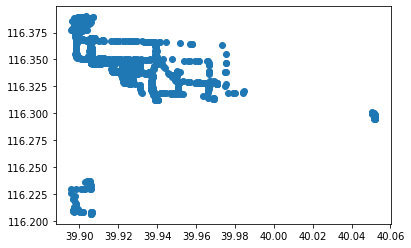

In [10]:
plt.scatter(data = data[['lat','lon']], x ='lat', y ='lon')

In [11]:
# Training
g_optimizer, d_optimizer = get_optimizers(param["optimizer"])

In [12]:
dp = GAN(
    param["input_dim"],
    param["random_dim"],
    param["discriminatorDims"],
    param["generatorDims"],
    g_optimizer,
    d_optimizer
)
d_dims = '_'.join([str(x) for x in param["discriminatorDims"]])
g_dims = '_'.join([str(x) for x in param["generatorDims"]])
bsize = str(param["batch_size"])

generator created...
discriminator created...


2022-05-04 21:33:59.187543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
data_conjoint, user_conjoint = get_data_user_conjoined(data)

In [14]:
# Scale if necessary
data_scaled, scaler = get_data(data_conjoint,scale_data)

In [15]:
# Get min and max of Long, Lat and hour
"""
if not scale_data:
    data_limits = {}
    for col in data_scaled.columns:
        data_limits[col] = {}
        data_limits[col]['min'] = data_scaled[col].min()
        data_limits[col]['max'] = data_scaled[col].max()
    dp.data_limits = data_limits
"""

"\nif not scale_data:\n    data_limits = {}\n    for col in data_scaled.columns:\n        data_limits[col] = {}\n        data_limits[col]['min'] = data_scaled[col].min()\n        data_limits[col]['max'] = data_scaled[col].max()\n    dp.data_limits = data_limits\n"

In [16]:
#dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(50000).batch(param["batch_size"], drop_remainder=True)
print(pd.DataFrame(data_scaled).head())
dataset = tf.convert_to_tensor(pd.DataFrame(data_scaled))

        time-f        lat         lon     lat_sqrd      lon_sqrd  lat_lon_sqrd
94345       10  39.905324  116.384240  1592.434884  13545.291320  15137.726204
104853      11  39.898930  116.368191  1591.924615  13541.555877  15133.480492
52373        4  39.899650  116.385406  1591.982070  13545.562730  15137.544800
4225        11  39.966243  116.324677  1597.300580  13531.430479  15128.731059
58299        0  39.922737  116.337532  1593.824930  13534.421352  15128.246281


G loss:  0.5720161  D loss:  0.8961602  step:  0
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-1.2945305  -0.44389564 -0.29765746 ... -0.520959   -0.33803535
 -0.61445224]


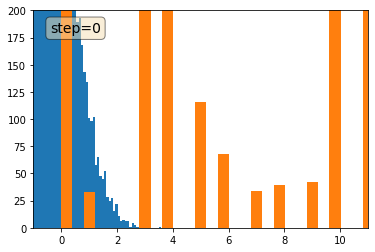

G loss:  0.47497147  D loss:  1.1063755  step:  100
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-0.4707688  -0.34149766  0.61782    ...  0.9619706  -1.6629708
  0.81259674]


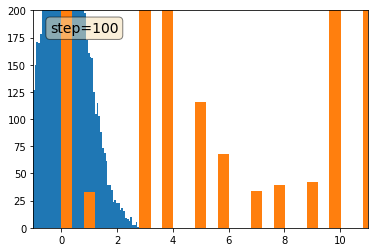

G loss:  0.8614505  D loss:  1285.4619  step:  200
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 1.6962051  -0.45081395  1.6716441  ...  0.28068686  1.2992097
 -0.02332726]


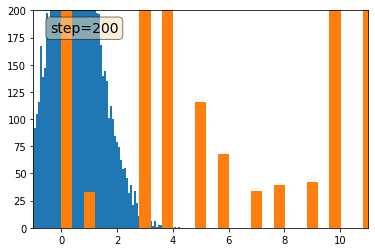

G loss:  0.84969807  D loss:  1854.13  step:  300
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-1.2360795   1.3052702  -1.2457391  ...  0.31898454 -0.1504766
  0.00263131]


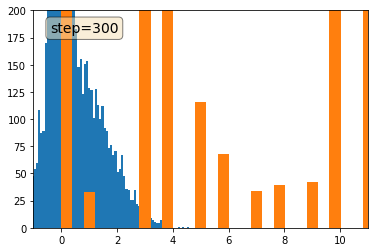

G loss:  0.90234846  D loss:  2113.565  step:  400
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 0.08046805 -0.16706726 -0.45142996 ...  0.20994878 -0.08667024
 -0.14486024]


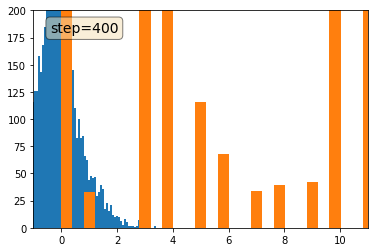

G loss:  0.9916669  D loss:  2282.0952  step:  500
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-0.36395618 -1.7941605   0.97209877 ... -0.04456553  0.0060272
 -0.15772592]


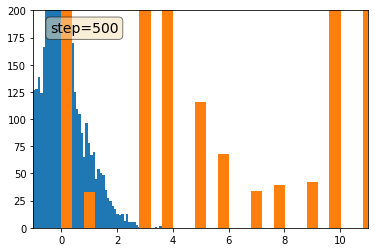

G loss:  1.0093826  D loss:  2409.7292  step:  600
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 2.5365126   1.30953     0.40640178 ... -0.08787656 -0.12100124
 -0.05723011]


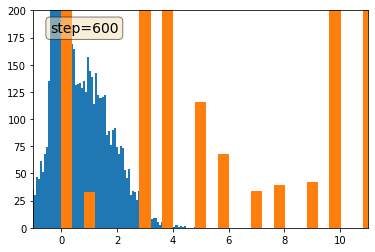

G loss:  1.0950371  D loss:  2509.4521  step:  700
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 7.8666276e-01 -5.6212968e-01  7.8230929e-01 ...  1.7351653e-01
 -2.5401786e-01 -7.0569990e-04]


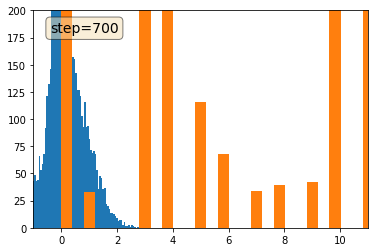

G loss:  1.1317904  D loss:  2565.2693  step:  800
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-2.2172775  -1.872663   -1.7083586  ...  0.1324934   0.04193612
 -0.0901095 ]


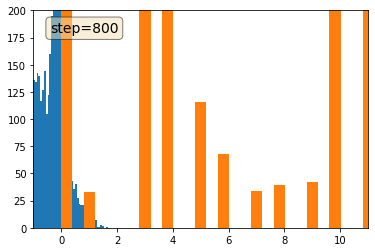

G loss:  1.2188169  D loss:  2605.493  step:  900
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 0.8592134   0.9061091   0.03370446 ...  0.25432476  0.24070087
 -0.10497463]


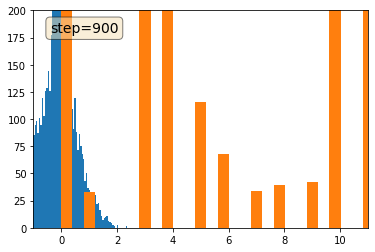

G loss:  1.2340506  D loss:  2684.5225  step:  1000
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 0.838942    1.0279195   0.6604974  ... -0.05556772  0.23781443
  0.0778949 ]


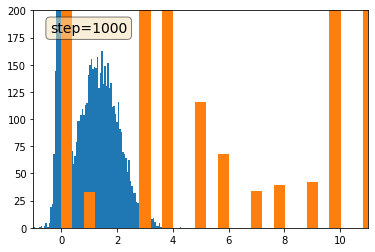

G loss:  1.3747663  D loss:  2772.8958  step:  1100
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 0.5593162   0.5667707   0.15328991 ...  0.16933067 -0.11165664
 -0.18002476]


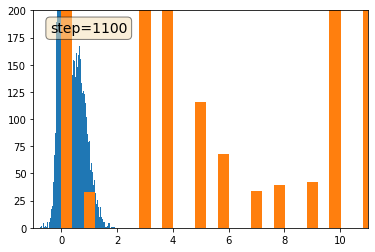

G loss:  1.2965417  D loss:  2828.3694  step:  1200
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 0.23272175 -1.8511167  -2.1913478  ... -0.09473485  0.01846793
  0.24872124]


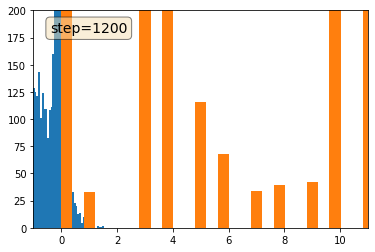

G loss:  1.5294014  D loss:  2854.466  step:  1300
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-1.3393707  -1.7709252  -1.2101817  ... -0.00205835 -0.13300635
  0.05023379]


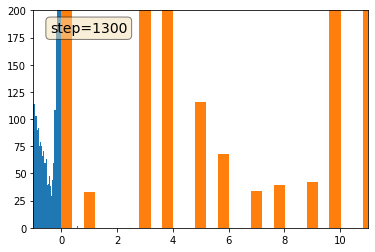

G loss:  1.4962393  D loss:  2888.3713  step:  1400
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 1.0018128   0.08882009 -0.39981514 ...  0.13008146 -0.18599541
  0.23847102]


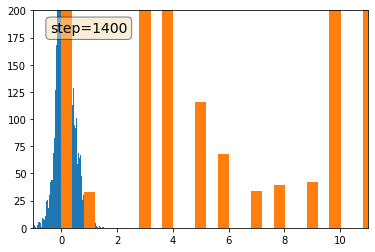

G loss:  1.5238411  D loss:  2983.8262  step:  1500
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[1.836307   1.8336282  1.9511002  ... 0.06772594 0.09890126 0.10818677]


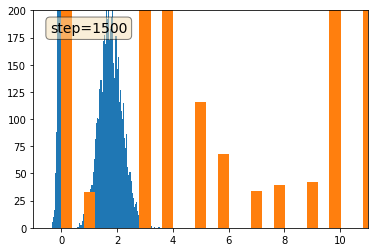

G loss:  1.7259837  D loss:  3086.3127  step:  1600
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[ 1.3056964   0.9503196   0.7296843  ... -0.03145158  0.04574169
  0.20368336]


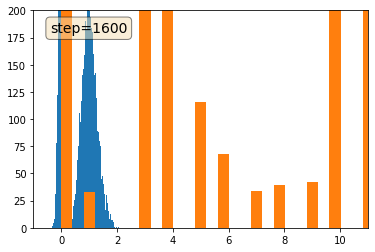

G loss:  1.688984  D loss:  3153.9631  step:  1700
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-0.5041068  -0.5100785  -0.44434026 ...  0.03398328 -0.03346743
 -0.01558883]


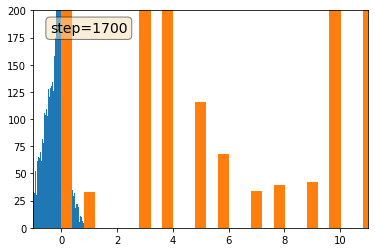

G loss:  1.7028672  D loss:  3187.3203  step:  1800
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-1.1428013  -1.9302429  -2.0427222  ...  0.01473686  0.03830503
  0.09119664]


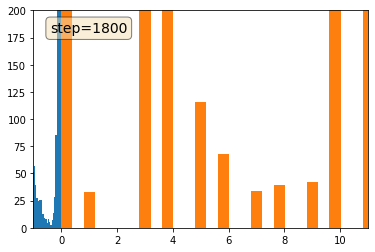

G loss:  1.9526588  D loss:  3200.1448  step:  1900
[10.       11.        4.       ... 39.926193 39.900247 39.900934]
[-1.8432524  -1.3005954  -0.936092   ...  0.02178835  0.10383543
  0.06615562]


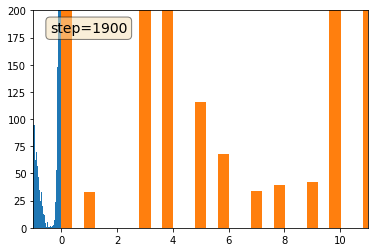

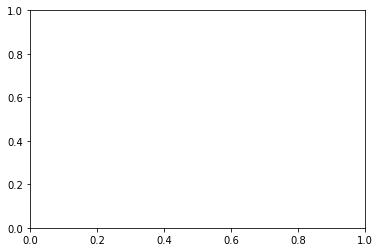

In [17]:
results = dp.train(dataset, nepochs, param["batch_size"])